# Regression Models

Regression aims to estimate the world state $w$ for a given observations $\mathbf{x}$ by modeling $P(w|\mathbf{x})$ based on obtained data $\{\mathbf{x}_{i}, w_{i}\}_{i=1}^N$.

## Table of contents:
* [Maximum Likelihood Linear Regression](#ml-linear-regression)
* [Bayesian linear regression](#bayesian-linear-regression)
* [Non-linear regression - Maximum Likelihood](#non-linear-regression-ml)
* [Non-linear regression - Bayesian Inference](#non-linear-regression-bayes)
* [Kernels and Gaussian process regression](#kernel-gaussian-process-regression)
* [Sparse linear regression](#sparse-linear-regression)
* [Dual linear regression](#dual-linear-regression)
* [Relevance vector regression](#relevant-vector-regression)
* [Regression to multivariate data](#multivariate-data)

# Kernel relevance vector regression <a class="anchor" id="relevant-vector-regression"></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [459]:
def generate_nice_params(ng, intvl):
    """
    Arguments:
        ng:    scalar. number of gaussians.
        intvl: scalar. distance between the means of gaussians.

    Output:
        lmd: scalar. std of the gaussians.
        wgt: weight distribution of the gaussians.  (ng+1, )
        sg:  scalar. noise rides on top of the generated curve.
    """
    lmd = intvl + (np.random.rand() - .5)
    wgt = 3 * np.random.rand(ng + 1) + .5
    sg = 0.2 * wgt.mean()
    wgt *= np.random.choice([-1, 1], ng + 1)
    wgt[0] = 50 * (np.random.rand() - .5)
    return lmd, wgt, sg**2


def generate_samples(ng, nx, ns, wgt, lmd, sg, x):
    """
    Arguments:
        ng:   scalar. number of gaussians.
        nx:   scalar. number of points between xlim (-10. and +10.) -> grid.
        ns:   scalar. number of samples
        wgt:  weight distribution of the gaussians.  (ng+1, )
        lmd:  scalar. std of the gaussians.
        sg:   scalar. noise rides on top of the generated curve.
        x:    x coodinates of the grid.
    
    Output:
        bases:     The basis gaussians on the grid. (ng+1 x nx) 1 for bias.
        bases_smp: The basis gaussians sampled from the grid. (ng x ns) 
        grdtr:     The generated curve. ground truth. (1, ng)
        cntrs:     The centers of the gaussians. (ng, )
        xs:        sampled x (ns, ) 
        smp:       sampled from grdtr added with sg noise, (ns, )
        
    """
    cntrs = np.arange(-lmd * (ng - 1) / 2, lmd * (ng + 1) / 2, lmd)
    bases = np.zeros((ng + 1, nx))
    bases[0, :] = np.ones(nx)
    for i in range(1, ng + 1, 1):
        bases[i, :] = spst.norm.pdf(x, cntrs[i - 1], 0.4 * lmd)
    grdtr = np.dot(wgt.T, bases)
    idx = np.random.choice(np.arange(nx), ns, replace=False)
    idx.sort()
    xs = x[idx]
    smp = grdtr[:, idx] + np.random.normal(0, sg, ns)
    bases_smp = bases[:, idx]
    return bases, bases_smp, grdtr, cntrs, xs, smp.T


def plot_samples(x, wgt, bases, grdtr, xs, smp):
    """
    Arguments:
        x:     x coodinates of the grid.
        wgt:   weight distribution of the gaussians.  (ng+1, )
        bases: The basis gaussians on the grid. (ng+1 x nx) 1 for bias.
        grdtr: The generated curve. ground truth. (1, ng)
        xs:    sampled x. (ns, )
        smp:   sampled from grdtr (ns, )
    
    Output:
        plot of grdtr, wgt * bases, smp
        
    """
    for i in range(1, bases.shape[0]):
        plt.plot(x, (wgt * bases)[i], '-')
    plt.plot(x, grdtr.squeeze(), 'k-', lw = 3)
    plt.plot(xs, smp.squeeze(), 'k.', markersize = 5)
    plt.xlabel("x")
    plt.ylabel("w")


def generate_colorscale(smp):
    """
    Arguments:
        smp:   sampled from grdtr added with sg noise, (ns, )
        
    Output:
        clrs:  color scale (3, ns)    
        
    """
    smpmax = smp.max()
    smpmin = smp.min()
    smpscaled = (smp - smpmin)/(smpmax - smpmin)
    clrs = np.hstack((1 - smpscaled, 1 - smpscaled, 0.8*smpscaled)).squeeze()
    return clrs


def plot_lg_pdf(phi, nres):
    """
    Arguments:
        phi:  slope of the plane.
        nres:  resolution of the image.
    
    Output:
        plot.
    """
    D = phi.shape[0]
    if D == 3:
        nn = nres**2
        xres = np.linspace(-10, 10, nres)
        yres = np.linspace(-10, 10, nres)
        yg, xg = np.meshgrid(yres, xres)
        x_flat = xg.reshape(1, nn)
        y_flat = yg.reshape(1, nn)
        x1_flat = np.vstack((np.ones(nn), x_flat))
        xy1_flat = np.vstack((x1_flat, y_flat))
        z = np.dot(phi[np.newaxis, :], xy1_flat).reshape((nres, nres)).T
        z = np.fliplr(z)
        plt.imshow(z, extent=[-10, 10, -10, 10])
        plt.arrow(0, 0, 5*phi[1], 5*phi[2], head_width=0.5, head_length=1., fc='k', ec='k')
        return z
    elif D == 2:
        xres = np.linspace(-10, 10, nres)
        x1_flat = np.vstack((np.ones(nres), xres))
        z = np.dot(phi[np.newaxis, :], x1_flat)
        zrep = np.tile(z, (nres, 1))
        zrep = np.fliplr(zrep)
        plt.imshow(zrep, extent=[-10, 10, -10, 10])
        plt.arrow(0, 0, 5*phi[1], 0, head_width=0.5, head_length=1., fc='k', ec='k')
        return zrep
    else:
        print('We don''t cover such case here')


def e_step(sgs, hs, nu, xt_x, xt_x2, xt_x_w):
    """
    Arguments:
        xs:    z star. (ng+1 x nres**2) D x N*
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgs:   scalar. this std squared.
        hs:    latent variable h's (D,)
    
    Output:
        hnew:  updated hs. (D, )
        mu:    mu evaluated for each xs (D, 1)
        sgm:   cov evaluated for each xs (D, D)
        
    """
    # w = N x 1
    # xs = D x N
    # pinv = D x D
    # mu = N x 1
    # hnew = D x 1
    A = xt_x2/sgs + np.diag(hs)
    A_inv = np.linalg.inv(A)
    sgma = A_inv
    mu = np.dot(A_inv, xt_x_w)/sgs
    hnew = 1 + nu - hs * np.diag(sgma)
    hnew /= mu.squeeze()**2 + nu
    return hnew, mu, sgma


def m_step(w, hs, mu, sgma, xt_x):
    dlt = w - np.dot(xt_x, mu)
    denom = (hs * np.diag(sgma)).sum()
    sgsnew = (dlt**2).sum()
    sgsnew /= denom
    return sgsnew


def kernel_rbf(x1, x2, alp):
    """
    Arguments:
        x1:    D x N1 
        x2:    D x N2
        alp:   scalar. std of the gaussians.
    
    Output:
        exp_dlt2:  kernel matrix. N1 x N2
        
    """
    assert x1.shape[0] == x2.shape[0], 'axis0 of the inputs should be equal'
    if np.array_equal(x1, x2):
        N1 = x1.shape[1]
        x12 = np.dot(x1.T, x1)
        x11 = np.diag(x12)[:, np.newaxis]
        x22 = x11.T
        diagX11 = np.tile(x11, [1, N1])
        diagX22 = np.tile(x22, [N1, 1])
        X12 = diagX11 - 2 * x12 + diagX22
        X12 *= -0.5 / (alp**2)
        exp_X12 = np.exp(X12)
    else:
        N1 = x1.shape[1]
        N2 = x2.shape[1]
        x11 = (x1**2).sum(axis=0, keepdims=1)
        x22 = (x2**2).sum(axis=0, keepdims=1)
        diagX11 = np.tile(x11.T, [1, N2])
        diagX22 = np.tile(x22, [N1, 1])
        x12 = np.dot(x1.T, x2)
        X12 = diagX11 - 2 * x12 + diagX22
        X12 *= -0.5 / (alp**2)
        exp_X12 = np.exp(X12)
    return exp_X12


def bayesian_inference(xs, x, w, hs, sg, alp):
    """
    Arguments:
        zs:    z star. (ng+1 x nres**2) D x N*
        z:     bases_smp. z coodinates of the samp. (ng+1 x ns)
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgp:   scalar. prior std.
        sg:    sg candidates. (100, )
    
    Output:
        cinv:  inverse of C (ng+1 x ng+1)
        
    """
    # w = N x 1
    # x = D x N
    # xs = D x N*
    # A = N x N
    # mu = N* x 1
    # cov = N* x 1
    D = x.shape[0]
    N = x.shape[1]
    sgs = sg**2
    
    xt_x = kernel_rbf(x, x, alp)
    A = np.dot(xt_x, xt_x)/sgs + np.diag(hs)
    A_inv = np.linalg.inv(A)
    xst_x = kernel_rbf(xs, x, alp)
    xt_x_w = np.dot(xt_x, w)
    
    xst_x_A_inv = np.dot(xst_x, A_inv)
    sgm = (xst_x_A_inv * xst_x).sum(axis=1) + sgs
    mu = np.dot(xst_x_A_inv, xt_x_w) / sgs
    return mu, np.sqrt(sgm)

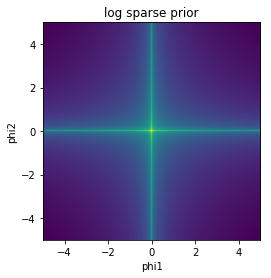

In [460]:
x = np.arange(-5, 5.1, .05)
nu = 0.0001
tx = spst.t.pdf(x, nu, loc=0, scale=1)
txy = np.outer(tx, tx)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.imshow(np.log(txy), extent=[-5, 5, -5, 5])
plt.title('log sparse prior')
plt.xlabel('phi1')
plt.ylabel('phi2')

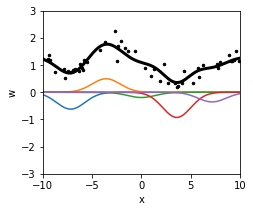

In [465]:
ns = 50
sgp = 5
ng = 5
nx = 201

x_range = np.array([-10., 10.])
xres = np.linspace(-10, 10, nx)
span = x_range[1] - x_range[0]
intvl = span / (ng + 1)
lmd = intvl + (np.random.rand() - .5)
wgt = 3 * np.random.rand(ng + 1) + .5
wgt *= np.random.choice([-1, 1], ng + 1)
wgt[0] = 4 * (np.random.rand() - .5)
wgt = wgt[:, np.newaxis]

sg = 0.2 #2 * np.random.rand() + 0.5
sgp = 0.05 * np.random.rand() + 0.01
psi = np.random.normal(0, sgp, (ns, 1))

bases, bases_smp, grdtr, cntrs, xs, smp = generate_samples(ng, nx, ns, wgt, lmd, sg, xres)
xs1 = np.vstack((np.ones(ns), xs))

plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.subplot(1,3,1)
plot_samples(xres, wgt, bases, grdtr, xs, smp)
plt.xlim(x_range)
plt.ylim([-3., 3.])
plt.xlabel("x")
plt.ylabel("w")

222 steps done: 
0.60, 104.52, 136.79, 166.92, 267.55, 162.17, 130.72, 4.11, 58.33, 136.64, 163.64, 154.46, 140.48, 102.54, 80.05, 56.16, 1.86, 85.75, 0.84, 1.07, 36.31, 50.65, 93.06, 125.84, 114.69, 0.58, 378.65, 375.88, 290.80, 2.76, 194.75, 339.49, 412.28, 384.49, 360.95, 196.93, 20.83, 131.76, 147.47, 134.86, 2.29, 3.39, 54.63, 99.76, 155.42, 126.69, 106.89, 59.10, 0.74, 71.77, 


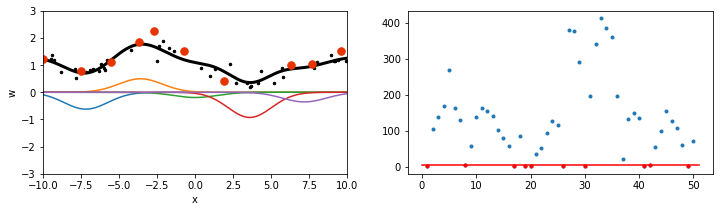

In [479]:
Nrep = 1000
hs = np.ones(ns)
import copy
################
alp = 1.0
cutoff = 5
################
xt_x = kernel_rbf(xs1, xs1, alp)
xt_x2 = np.dot(xt_x, xt_x)
xt_x_w = np.dot(xt_x, smp)
for i in range(Nrep):
    temp = copy.deepcopy(hs)
    hs, mu, sgma = e_step(sgs, hs, nu, xt_x, xt_x2, xt_x_w)    
    sgs = m_step(smp, hs, mu, sgma, xt_x)
    if np.max(np.abs(hs - temp)/temp) < 0.001:
        break

strng = '{} steps done: \n'.format(i)
for h in hs:
    strng += '{:1.2f}, '.format(h)
print(strng)

sel = np.where(hs < cutoff)[0]
xs1_sel = xs1[:, sel]
smp_sel = smp[sel]
hs_sel = hs[sel]

plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.subplot(1,2,1)
plot_samples(xres, wgt, bases, grdtr, xs, smp)
plt.xlim(x_range)
plt.ylim([-3., 3.])
plt.xlabel("x")
plt.ylabel("w")
plt.plot(xs[sel], smp[sel], '.', markersize=15, color=(0.9, 0.2, 0.0))

plt.subplot(1,2,2)
plt.plot(np.arange(hs.shape[0])+1, hs, '.')
plt.plot(sel+1, hs[sel], 'r.')
plt.plot([0, hs.shape[0]+1], cutoff*np.ones(2), 'r-')

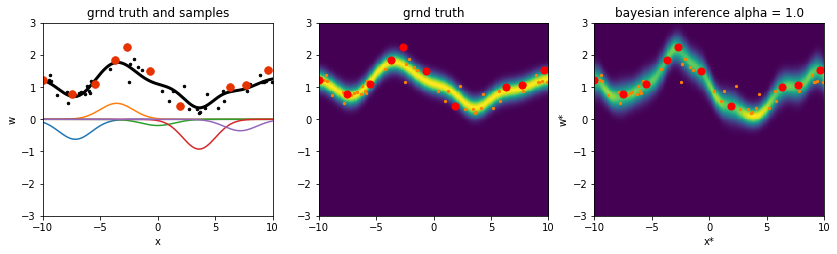

In [481]:
plt.rcParams['figure.figsize'] = (14.0, 18.0)

nres = nx
nn = nres**2
xres = np.linspace(-10, 10, nres)
yres = np.linspace(-3, 3, nres)
xg, yg = np.meshgrid(xres, yres)
xss = xg.reshape(1, nn)
yss = yg.reshape(1, nn)
xss1 = np.vstack((np.ones(nn), xss))
    
ax1 = plt.subplot(1,3,1)
plot_samples(xres, wgt, bases, grdtr, xs, smp)
plt.plot(xs[sel], smp[sel], '.', markersize=15, color=(0.9, 0.2, 0.0))
plt.xlim(x_range)
plt.ylim([-3., 3.])
plt.xlabel("x")
plt.ylabel("w")
plt.title('grnd truth and samples')
ax1.set_aspect(2.8)

ax2 = plt.subplot(1,3,2)
lg_pdf = spst.norm.pdf(yss, np.kron(np.ones(nres),grdtr), sg).reshape((nres, nres))
lg_pdf = np.flipud(lg_pdf)
plt.imshow(lg_pdf, extent=[-10, 10, -3, 3])
plt.scatter(xs1[1].squeeze(), smp.squeeze(), s=5, c=(1.0, 0.5, 0.0))
plt.scatter(xs1_sel[1].squeeze(), smp_sel.squeeze(), s=50, c=(1.0, 0.0, 0.0))
plt.xlim(-10, 10.)
plt.ylim(-3, 3)
ax2.set_aspect(2.8)
plt.title('grnd truth')

ax3 = plt.subplot(1,3,3)
mu, cov = bayesian_inference(xss1, xs1_sel, smp_sel, hs_sel, sg, alp)
brg_pdf = spst.norm.pdf(yss.squeeze(), mu.squeeze(), cov.squeeze()).reshape((nres, nres))
brg_pdf = np.flipud(brg_pdf)
plt.imshow(brg_pdf, extent=[-10, 10, -3, 3])
plt.scatter(xs1[1].squeeze(), smp.squeeze(), s=5, c=(1.0, 0.5, 0.0))
plt.scatter(xs1_sel[1].squeeze(), smp_sel.squeeze(), s=50, c=(1.0, 0.0, 0.0))
plt.title("bayesian inference alpha = {}".format(alp))
plt.xlabel("x*")
plt.ylabel("w*")
plt.xlim(-10, 10.)
plt.ylim(-3, 3)
ax3.set_aspect(2.8)